In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import microscopy_data_analysis as mda

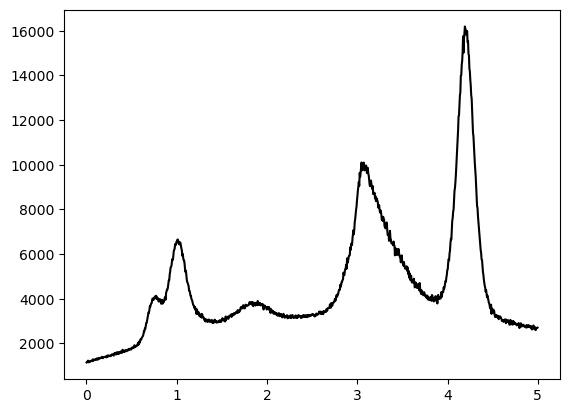

In [2]:
# get dummy data
import peak_fit_data_production
x,y=peak_fit_data_production.run_script()
plt.plot(x,y,c='k')

# Peak-Fit Analysis

For a background subtraction with SNIP a value $m$ is needed, that is around half the size of the peaks.  
A rough estimate by eye assessig the width of the peaks gives: smaller than 1 and maybe bigger than 0.1  
So let's try values in between half of these bounds. 

In [3]:
mvals=np.linspace(0.05,0.5,10)
possible_backgrounds=[]
for m in mvals:
    possible_backgrounds.append(mda.snip(y,m=m,x_data=x))

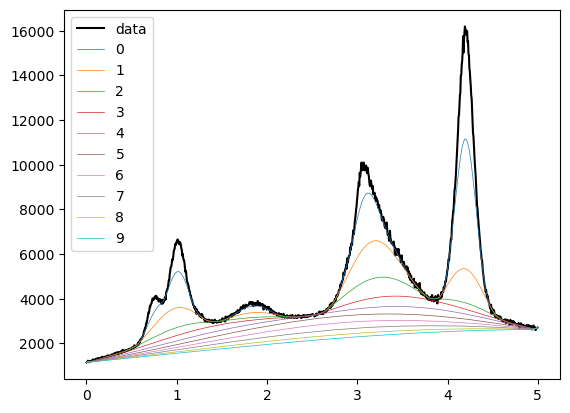

In [4]:
# plot the result
plt.plot(x,y,c='k',label='data')
for i in range(len(possible_backgrounds)):
    plt.plot(x,possible_backgrounds[i],lw=0.5,label=str(i))

plt.legend()
plt.show()

In [5]:
# choose purple curve (index 4)
background=possible_backgrounds[4]
corrected_y=y-background

# make sure to prevent negative values occuring after the background subtraction
# if there were no negative values, erasing the offset from 0 is also not bad 
corrected_y-=np.min(corrected_y)

# obtain the peak positions
maximum_positions=mda.get_n_peaks_1d(corrected_y,x,n=5)
print("peak positions in descending order:") 
print(str(maximum_positions))

# obtain regions of ineterest limiting each peak by lower and upper bounds
roi_tuples=mda.create_rois(corrected_y,peak_positions=maximum_positions,x_data=x)

peak positions in descending order:
[4.1925 3.0475 1.0125 0.7725 1.8075]


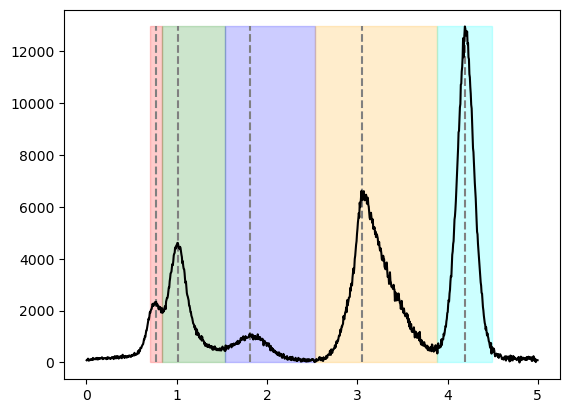

In [6]:
# Plot the results to check correctness

ymax=np.max(corrected_y)
ymin=np.min(corrected_y)
plt.vlines(maximum_positions,ymin,ymax,color='grey',ls='--')

plt.plot(x,corrected_y,c='k')
ax=plt.gca()
colors=['r','g','b','orange','cyan']
for i in range(len(roi_tuples)):
    xleft=roi_tuples[i][0]
    xright=roi_tuples[i][1]
    rect = matplotlib.patches.Rectangle((xleft,0),xright-xleft, ymax-ymin, alpha=0.2,color=colors[i])
    ax.add_patch(rect)
plt.show()

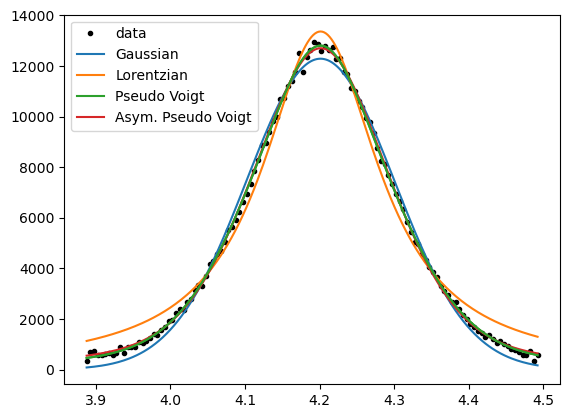

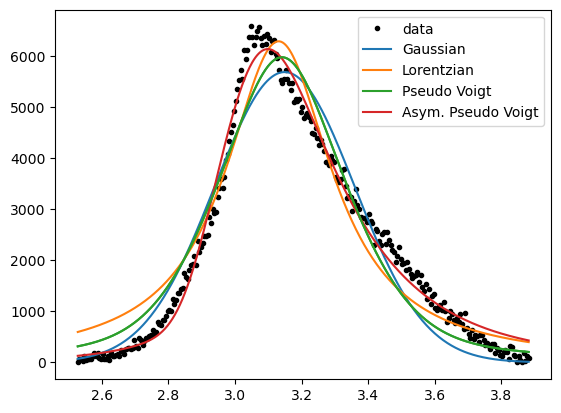

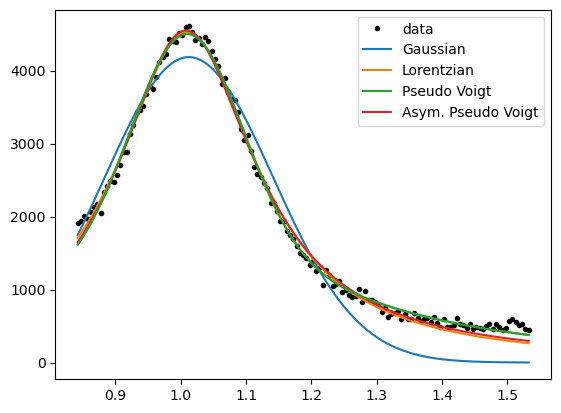

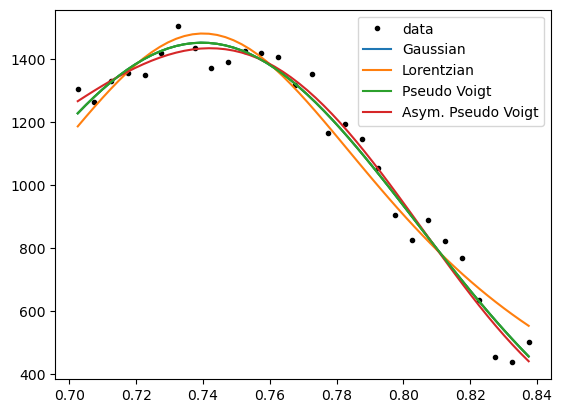

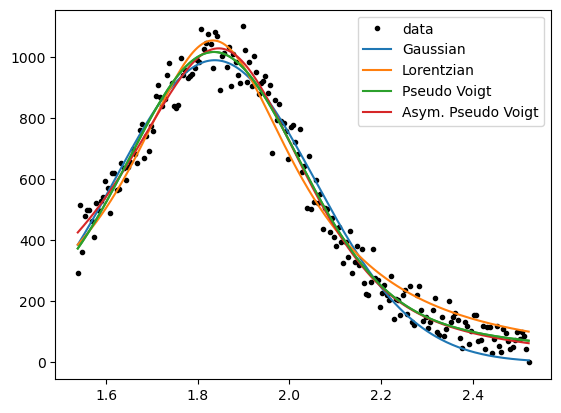

In [7]:
# fit each peak individually within the corresponding region of interest
parameters,fitted_y=mda.sequential_peak_fit(corrected_y,x,regions_of_interest=roi_tuples,plot=True)

We see the peaks being fitted differently well by varying functions.  
It is good practice to choose the simplest function, that satisfies a "good" fit to the data.  
Gaussian and Lorentzian curves differ in their shape, so if one fits the data well, the other should not.  
In contrast, the pseudo-Voigt function can take the shape of the two more simple functions,  
and the asymmetric pseudo-Voigt function can be similar to all before mentioned functions.  
Thus, the asymmetric pseudo-Voigt function should always give the best fit, 
but less complex functions should be preferred.     
However, for an overview analysis of unknown peaks, it is useful to continue with this "Allrounder"-fit-function.  
Because a look into the parameter-values afterwards will show, if a simpler function would me more appropriate.  
(e.g. if the parameters "eta" for the mixture of Gaussian and Lorentzian is close to 0 or 1) 

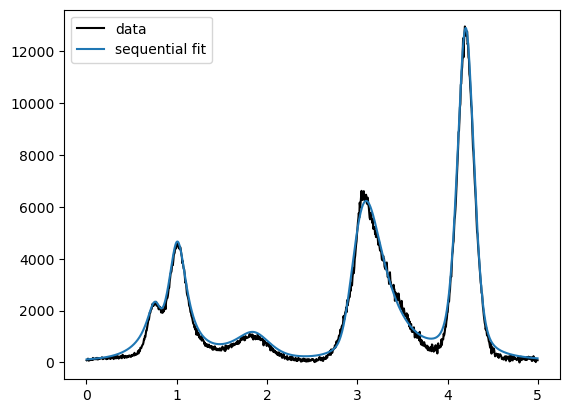

In [8]:
# so the total fitted curve from sequential_peak_fit is the sum of all peaks,
# always using asym_pseudo_voigt
plt.plot(x,corrected_y,c='k',label='data')
plt.plot(x,fitted_y,label='sequential fit')
plt.legend()
plt.show()

While the fit is not bad, the influence of peaks to each other was calculated in one direction only.  
As sequential fitting starts with the biggest peak, no influence of smaller to bigger peaks is considered.  
Now, that we have reasonable parameter values for all peaks, we can try to vary all of them simultaneously.

In [9]:
# the function for multiple-identical-functions-fitting can take any function,
# so we need to provide the fit-function and also the corresponding parameter-bounds
# (preventing unreasonable values like, negative peak-amplitudes) 
lower_bounds,upper_bounds=mda.asym_pseudo_voigt_parameter_bounds()
sparams,simult_y=mda.multi_ident_func_fit(mda.asym_pseudo_voigt,parameters,x,corrected_y,
                                          single_lower_bounds=lower_bounds,single_upper_bounds=upper_bounds)

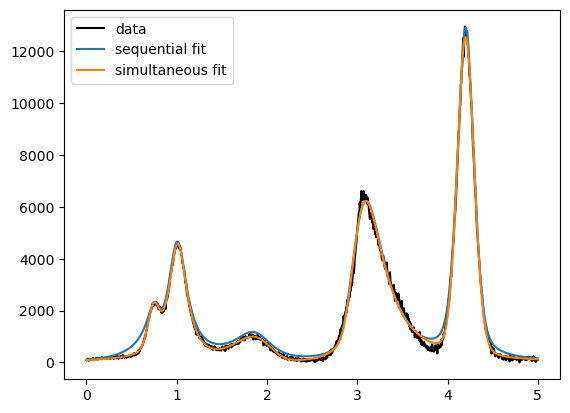

In [10]:
plt.plot(x,corrected_y,c='k',label='data')
plt.plot(x,fitted_y,label='sequential fit')
plt.plot(x,simult_y,label='simultaneous fit')
plt.legend()
plt.show()

The simultaneous fit shows a better approximation to the data in regions not directly on the peaks.   
Also the quality of the fit of the smallest peaks usually increases. 

In [11]:
parameter_table=mda.asym_pseudo_voigt_table(sparams)

,$x_0$,$x_{center}$,amplitude $A$,peakheight,$\eta$,Gaussian,Lorentzian,width $\gamma_0$,asym. $a$,norm. $a$,$x_0-x_{center}$
peak 1,7.409e-01,7.391e-01,2.137e+02,1.415e+03,0.000,0.0%,100.0%,1.419e-01,5.049e-01,0.036,1.835e-03
peak 2,1.010e+00,9.880e-01,1.799e+03,4.568e+03,1.000,100.0%,0.0%,2.507e-01,5.862e-01,0.073,2.199e-02
peak 3,1.831e+00,1.796e+00,4.705e+02,9.109e+02,0.062,6.2%,93.8%,4.756e-01,7.547e-01,0.178,3.482e-02
peak 4,3.134e+00,3.282e+00,3.646e+03,6.046e+03,0.594,59.4%,40.6%,4.581e-01,-2.684e+00,-0.547,-1.486e-01
peak 5,4.202e+00,4.205e+00,3.074e+03,1.229e+04,0.193,19.3%,80.7%,2.204e-01,-2.132e-01,-0.023,-2.675e-03


In [12]:
# here "norm. a" is the normalized asymmetry parameter "a" covering a range between -1 and 1.
# (Also erasing the influence of gamma_0 on a, allowing better comparison of asymmetry for different peaks.
# Similarly the last column could be divided by gamma_0 aswell.)